<a href="https://colab.research.google.com/github/Kyoung-mii/DeepLearning/blob/main/02_MultilayerPerceptronAndBackpropagation/2_4_BackpropagationBasedTrainingForAMultiClassMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2-2 [1] 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

# 2-2 [2] 데이터 준비 함수 정의하기

In [2]:
def prepare_data():
    iris = load_iris()    # iris data set 읽기
    X = iris.data[:, 2:]  # 4개의 특징 중 꽃잎의 길이와 폭 선택
    y = iris.target       # 각 표본의 레이블ㄹ
    lbl_str = iris.target_names # 'setosa','versicolor','virgnica'
    return X, y, lbl_str

# 2-2 [3] 활성함수 - 시그모이드와 소프트 맥스

In [3]:
def sigmoid(x):
    ''' x : numpy array '''
    return 1 / (1 + np.exp(-x))

def softmax(x):
    ''' x : numpy array '''
    o = np.exp(x)
    return o / o.sum()

# 2-2 [4] 손실함수 - mse, cross entropy

In [9]:
def loss_mse(y, y_hat):
    loss = 0.0
    for i in range(len(y)):
        err = y_hat[i] - y[i]
        loss += np.dot(err, err)
    return loss / len(y)

def loss_ce(y, y_hat):
    loss = 0.0
    if len(y.shape) == 1 or y.shape[1] == 1:
        for i in range(len(y)):
            loss += -(y[i] * np.log(y_hat[i])
            + (1-y[i]) * np.log((1 - y_hat[i]))).sum()
    else:
        for i in range(len(y)):
            loss += -(y[i] * np.log(y_hat[i])).sum()
    return loss / len(y)

# 2-2 [5] Dense 클래스 - 완전 연결층

In [4]:
class Dense():
    def __init__(self, nIn, nOut, activation = 'sigmoid', loss = 'mse'):
        self.nIn = nIn     # 입력의 수
        self.nOut = nOut   # 출력의 수
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        rnd = np.random.default_rng()
        self.w = rnd.normal(scale = np.sqrt(2.0 / self.nIn),
                            size = (self.nOut, self.nIn)).astype(np.float32)
        self.b = rnd.normal(scale = np.sqrt(2.0 / self.nIn),
                            size = (self.nOut)).astype(np.float32)
        # 활성 함수 설정
        if activation == 'softmax':
            self.activation = softmax
            self.dE_du = self.dE_du_softmax
        else: # 시그모이드
            self.activation = sigmoid
            if loss == 'ce' : self.dE_du = self.dE_du_sigmoid_ce
            else: self.dE_du = self.dE_du_sigmoid_mse
            self.do_du = self.do_du_sigmoid
        # 모멘텀을 적용하기 위한 속도의 초깃값 설정
        self.velocity_w, self.velocity_b = 0.0, 0.0

    # 입력 X에 대한 출력 계산
    def output(self, X):
        self.in_vec = X   # bp 학습을 위해 입력 보관
        # 입력의 가중 합 계산
        u = np.array([np.dot(self.w[i], X) + self.b[i]
                      for i in range(self.nOut)], dtype = np.float32)
        # 활성함수를 적용한 출력 계산
        self.out_vec = self.activation(u)   # bp 학습을 위해 출력 보관
        return self.out_vec

    # 경사 하강법에 따라 w 및 b 갱신
    def gd(self, dw, db, momentum = 0):
        self.velocity_w = self.velocity_w * momentum - dw
        self.velocity_b = self.velocity_b * momentum - db
        self.w += self.velocity_w
        self.b += self.velocity_b

    def dE_du_sigmoid_mse(self, y):
        return (self.out_vec - y) * self.do_du_sigmoid()

    def dE_du_sigmoid_ce(self, y):
        return self.out_vec - y

    def do_du_sigmoid(self):
        return self.out_vec * (1 - self.out_vec)

    def dE_du_softmax(self, y):
        return self.out_vec - y

# 2-2 [6] BP_Model 클래스

In [5]:
class BP_Model():
    def __init__(self, nUnitLst, loss = 'mse',
                 activation_h = 'sigmoid', activation_o = 'sigmoid'):
        layers = []
        self.nLayers = len(nUnitLst) - 1
        # 은닉층 구성
        for i in range(self.nLayers -1):
            layers.append(Dense(nUnitLst[i], nUnitLst[i+1],
                                activation = activation_h, loss = loss))
        # 출력층 구성
        layers.append(Dense(nUnitLst[self.nLayers - 1],
                            nUnitLst[self.nLayers], activation = activation_o, loss = loss))
        self.layers = np.array(layers, dtype= object)
        self.ohe = np.identity(nUnitLst[-1])
        if loss == 'ce':
            self.loss = loss_ce
        else:
            self.loss = loss_mse

    def predict(self, x):
        res = []
        for j in range(len(x)):
            xx = x[j]
            for i in range(self.nLayers):
                xx = self.layers[i].output(xx)
            res.append(xx)
        return np.array(res)

    def fit(self, X, y, N, epochs, eta = 0.01, momentum = 0):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        if self.layers[self.nLayers - 1].nOut == 1:
            y = np.array([[y[idx[i]]] for i in range(N)])
        else:
            y = np.array([self.ohe[y[idx[i]]] for i in range(N)])

        f = 'Epochs = {:4d}      Loss = {:8.5f}'
        # w와 b의 변화량을 저장할 수 있게 준비함.
        dw, db = [],[]
        for i in range(self.nLayers):
            dw.append(np.zeros((self.layers[i].nOut, self.layers[i].nIn),
                               dtype = np.float32))
            db.append(np.zeros(self.layers[i].nOut, dtype = np.float32))
        for n in range(epochs):
            for m in range(N):
                # output layer
                iCurrLayer = self.nLayers - 1
                currLayer = self.layers[iCurrLayer]
                self.predict([X[m]])
                delta = currLayer.dE_du(y[m])
                du_dw = currLayer.in_vec
                for j in range(currLayer.nOut):
                    dw[iCurrLayer][j] = eta * delta[j] * du_dw
                    db[iCurrLayer][j] = eta * delta[j]
                nextDelta = delta
                nextLayer = currLayer

                # hidden layers
                for iCurrLayer in range(self.nLayers-2, -1, -1):
                    currLayer = self.layers[iCurrLayer]
                    dE_do = []
                    for n0 in range(currLayer.nOut):
                        sDeltaW = nextDelta * nextLayer.w[:, n0]
                        dE_do.append(sDeltaW.sum())
                    delta = dE_do * currLayer.do_du()
                    du_dw = currLayer.in_vec
                    for j in range(currLayer.nOut):
                        dw[iCurrLayer][j] = eta * delta[j] * du_dw
                        db[iCurrLayer][j] = eta * delta[j]
                    nextDelta = delta
                    nextLayer = currLayer

                for i in range(self.nLayers):
                    self.layers[i].gd(dw[i], db[i])

            # 학습 과정 출력
            if n < 10 or (n + 1) % 100 == 0:
                y_hat = self.predict(X)
                print(f.format(n + 1, self.loss(y, y_hat)))

# 2-2 [7] 시각화

In [6]:
def visualize(net, X, y, multi_class, labels, class_id, colors,
              xlabel, ylabel, legend_loc = 'lower right'):
    # 데이터의 최소~최대 범위를 0.25 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:,0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max - x_min) * 20 + 1)
    y_lin = np.linspace(y_min, x_max, (y_max - y_min) * 20 + 1)

    # x_lin과 y_lin의 격자좌표의 x와 y값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k]) for k in range(len(y_hat))],
                         dtype = int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 및 각 클래스에 대한 색상 및 범례 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                    c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y==i, 0], X[y==i, 1],
                    c = c, s = 20, label = c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc = legend_loc)
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size = 12)
    plt.ylabel(ylabel, size = 12)
    plt.show()

# 2-2 [8] 훈련 데이터 준비하기

In [7]:
nSamples = 150
nDim = 2
nClasses = 3
X, y, labels = prepare_data()

# 2-2 [9] BP_Model 객체 생성 및 학습

In [10]:
bp_iris_multi = BP_Model([nDim, 4, nClasses], loss = 'ce',
                         activation_h = 'sigmoid', activation_o = 'softmax')
bp_iris_multi.fit(X, y, nSamples, epochs = 1000, eta = 0.01, momentum = 0.9)

Epochs =    1      Loss =  1.10568
Epochs =    2      Loss =  0.98421
Epochs =    3      Loss =  0.94217
Epochs =    4      Loss =  0.91441
Epochs =    5      Loss =  0.88989
Epochs =    6      Loss =  0.86586
Epochs =    7      Loss =  0.84155
Epochs =    8      Loss =  0.81673
Epochs =    9      Loss =  0.79159
Epochs =   10      Loss =  0.76662
Epochs =  100      Loss =  0.26820
Epochs =  200      Loss =  0.15792
Epochs =  300      Loss =  0.11729
Epochs =  400      Loss =  0.09943
Epochs =  500      Loss =  0.09033
Epochs =  600      Loss =  0.08502
Epochs =  700      Loss =  0.08166
Epochs =  800      Loss =  0.07943
Epochs =  900      Loss =  0.07789
Epochs = 1000      Loss =  0.07679


# 2-2 [10] 특징 공간 결정 영역 시각화

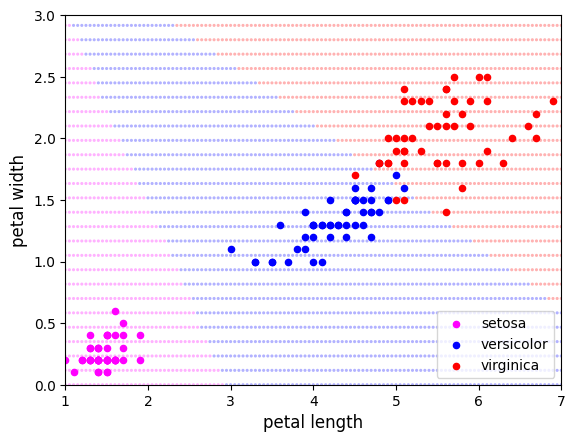

In [11]:
visualize(bp_iris_multi, X, y,
          multi_class = True,
          class_id = labels,
          labels = [0, 1, 2],
          colors = ['magenta', 'blue', 'red'],
          xlabel = 'petal length',
          ylabel = 'petal width')